# CO2的排量预测，使用pytorch lightning框架示例
## 导入所需的库

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import yeojohnson, yeojohnson_normmax, yeojohnson_llf
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from torch import nn
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar, RichProgressBar
from sklearn.model_selection import train_test_split
from pytorch_lightning import seed_everything
from sklearn.preprocessing import PowerTransformer

## 数据预处理

In [34]:
def preprocess_data(file_path):
    data = pd.read_csv(file_path, encoding='gbk')
    
    data['date'] = pd.to_datetime(data['date'])
    # data['entry_date'] = pd.to_datetime(data['entry_date'])
    # data['departure_date'] = pd.to_datetime(data['departure_date'])
    # 
    # data['duration'] = (data['departure_date'] - data['entry_date']).dt.days
    
    pt = PowerTransformer(method='yeo-johnson')
    data['CO2排放总量_transformed'] = pt.fit_transform(data['CO2排放总量'].values.reshape(-1, 1)) # 进行Yeo-Johnson变换
    # print(data['CO2排放总量'])
    # data = data.sort_values(by='duration', ascending=False)
    return data, pt
# preprocess_data('D:\Pycharm\chuan\data.csv')

In [35]:
def create_sequencesCO2(window): 
    data = pd.read_csv('D:\Pycharm\chuan\data3.csv', encoding='gbk')
    # data = data['CO2排放总量']
    pt = PowerTransformer(method='yeo-johnson')
    data = pt.fit_transform(data['CO2排放总量'].values.reshape(-1, 1)) # 进行Yeo-Johnson变换
    sequences = [] 
    targets = [] 
    for i in range(len(data) - window): 
        seq = data[i:i + window] 
        target = data[i + window] 
        sequences.append(seq) 
        targets.append(target) 
    x=np.array(sequences)
    y=np.array(targets)
    print(x.shape,y.shape)
    return x, y, pt

In [36]:
def create_sequences(window): 
    # 读取数据
    data = pd.read_csv('D:\\Pycharm\\chuan\\dataset\\Video1.csv', encoding='gbk')

    # 转换日期列为 datetime 对象
    data['Date'] = pd.to_datetime(data['Date'])

    # 提取日期特征
    # data['Year'] = data['Date'].dt.year
    # data['Month'] = data['Date'].dt.month
    # data['Day'] = data['Date'].dt.day
    # data['DayOfWeek'] = data['Date'].dt.dayofweek
    # data['DayOfYear'] = data['Date'].dt.dayofyear
    # data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)

    # 进行 Yeo-Johnson 变换
    pt = PowerTransformer(method='yeo-johnson')
    data['TransformedViews'] = pt.fit_transform(data['Views'].values.reshape(-1, 1))

    # 构造序列数据
    sequences = [] 
    targets = [] 
    for i in range(len(data) - window): 
        seq = data.iloc[i:i + window][['TransformedViews']].values
        target = data.iloc[i + window]['TransformedViews']
        sequences.append(seq) 
        targets.append(target) 

    x = np.array(sequences)
    y = np.array(targets)
    print(x.shape, y.shape)
    return x, y, pt

# 测试函数
# create_sequences(2)

## 数据变化（yeo-johnson）示例

In [37]:
from sklearn.preprocessing import PowerTransformer
import pandas as pd

# 示例数据
data = pd.DataFrame({'CO2排放总量': [10, 15, 30, 45, 50]})

# 创建 PowerTransformer 对象
# pt = PowerTransformer(method='yeo-johnson')
pt = PowerTransformer(method='box-cox')
# 拟合并变换数据
data['CO2排放总量_transformed'] = pt.fit_transform(data['CO2排放总量'].values.reshape(-1, 1))

# 打印变换后的数据
print(data)
print(data.shape)


   CO2排放总量  CO2排放总量_transformed
0       10            -1.371926
1       15            -0.901171
2       30             0.148815
3       45             0.945360
4       50             1.178922
(5, 2)


## 定义数据集（继承自Dataset）

In [38]:
class EmissionsDataset(Dataset):
    def __init__(self, x, y):
        self.features = x
        self.targets = y

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # 从数据集中获取单个样本的特征和标签，并将它们转换为 PyTorch 张量（Tensor）的格式，
        # 并添加一个维度作为批处理维度。
        # 特征：前几日排放量
        # 标签：后一天的CO2排放总量
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        return feature, target

## pl的数据模块

In [39]:
class EmissionsDataModule(pl.LightningDataModule):
    def __init__(self, hparams, features, targets, pt):
        super().__init__()
        self.batch_size = hparams.batch_size
        self.num_workers = hparams.num_workers
        self.features = features
        self.targets = targets
        
        # 变换器
        self.pt = pt
        # 随机种子
        self.init_seed = hparams.init_seed

    def setup(self, stage=None): # 划分数据集
        # 调用函数，生成dataset（处理好的数据集）
        dataset = EmissionsDataset(self.features, self.targets)
        
        # 划分数据集 （划分训练、验证、测试数据集）
        # 随机种子
        train_and_val_dataset, self.test_dataset = train_test_split(dataset, test_size=0.1, random_state=self.init_seed)
        self.train_dataset, self.val_dataset = train_test_split(train_and_val_dataset, test_size=0.1, random_state=self.init_seed)
        
    # 定义数据加载器：以小批量（mini-batch）的形式提供数据，从而实现批处理训练
    # num_workers：加载数据时使用的子进程数量。这可以加速数据加载过程，特别是当数据集较大时
    # shuffle：是否在每个 epoch 开始前对数据进行随机化，通常用于训练数据。
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

## 定义所有神经网络
### RNN

In [40]:
class RNNModel(nn.Module):
    # 定义RNN模型
    # hidden_dim：隐藏层维度
    # num_layers：RNN层数
    # input_dim：输入维度
    # output_dim：输出维度
    def __init__(self, hidden_dim=64, num_layers=2, input_dim=1, output_dim=1):
        super(RNNModel, self).__init__()
        # batch_first=True 表示输入数据的形状为 [batch_size, sequence_length, input_dim]
        # batch_size: 批处理大小，即一次处理的数据数量
        # sequence_length: 序列长度，即每个输入样本的长度,特征数量（NH3与CO2的排放量作为输入特征预测明天CO2排放量）= 2
        # input_dim: 输入维度，(今天的NH3排放量=1（size=1），昨天和今天的CO2排放量（size=2）)
        # shape:
        # [
        ##     [[8],[9,10]],
        #     [[2],[8,2]],
        #     [[3],[3,4]],
        # ]
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        )

    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

### GRU 结合 Transformer

In [41]:
class GRUModel(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=2, input_dim=1, output_dim=1):
        super(GRUModel, self).__init__()
        # GRU层
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        # 创建一个多头注意力层，输入的特征维度为 hidden_dim，使用2个注意力头
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=2)
        # 层归一化层
        self.ln = nn.LayerNorm(hidden_dim)
        # 前馈神经网络，包括两层线性变换和一个ReLU激活函数
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, hidden_dim)
        )
        # 线性层，用于将隐藏状态映射到输出维度
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 初始化 GRU 隐藏状态h0,大小为 (num_layers, batch_size, hidden_dim)，并将其移动到输入 x 的设备上（CPU或GPU）
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        # 通过GRU层：将输入 x 和初始隐藏状态 h0 传入GRU层，输出 out 是GRU的输出，第二个返回值是最后一个隐藏状态（在这里未使用）
        out, _ = self.gru(x, h0)
        # 将输出 out 传入注意力层，得到注意力加权后的输出 at_out 和注意力权重
        at_out, _ = self.attention(out, out, out)
        # 将注意力加权后的输出与原始输出相加（残差连接），并进行层归一化
        out = self.ln(out + at_out)
        # 将归一化后的输出传入前馈神经网络
        out = self.ffn(out)
        # 将前馈神经网络的输出传入线性层，得到最终的输出
        out = self.ln(out + at_out)
        # 提取最后一个时间步的输出 out[:, -1, :]，并通过全连接层得到最终输出
        out = self.fc(out[:, -1, :])
        return out

### LSTM

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=2, input_dim=1, output_dim=1, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        # 防止过拟合
        self.fc = nn.Sequential(nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 32), nn.ReLU(),nn.Linear(32, output_dim))
        self.batchnorm = nn.BatchNorm1d(hidden_dim * 2 if bidirectional else hidden_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # 初始化 LSTM 隐藏状态
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM 前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出，并送入全连接层
        # out = self.fc(out[:, -1, :])
        # 防止过拟合
        out = self.dropout(self.batchnorm(out[:, -1, :]))
        out = self.fc(out)
        return out
        # return out


### FC (Linear)

In [43]:
class FullyConnected(nn.Module):
    def __init__(self, hidden_dim=64, input_dim=1, output_dim=1, is_linear=False, window=1):
        super(FullyConnected, self).__init__()
        self.is_linear = is_linear
        self.window = window
        # 全连接层（线性层、激活层、线性层）
        self.fc1 = nn.Linear(input_dim * window, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # 单线性层
        self.only = nn.Linear(input_dim * window, output_dim)
    def forward(self, x):
        if self.is_linear:
            x = x.view(x.size(0), -1)
            x = self.only(x)
        else:
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
        return x

## pytorch lightning module
## 在这里，只需要将模型导入，并重写training_step, validation_step, test_step以及configure_optimizers

In [44]:
class EmissionsPredictor(pl.LightningModule):
    def __init__(self, hparams, pt):
        super(EmissionsPredictor, self).__init__()
        self.save_hyperparameters(hparams) # 保存超参数
        self.pt = pt
        self.model_type = hparams.model_type

        if self.model_type == 'RNN':
            self.model = RNNModel(input_dim=hparams.input_dim, hidden_dim=hparams.hidden_dim, num_layers=hparams.num_layers)
        elif self.model_type == 'GRU':
            self.model = GRUModel(input_dim=hparams.input_dim, hidden_dim=hparams.hidden_dim, num_layers=hparams.num_layers)
        elif self.model_type == 'LSTM':
            self.model = LSTMModel(input_dim=hparams.input_dim, hidden_dim=hparams.hidden_dim, num_layers=hparams.num_layers, bidirectional = hparams.bidirectional)
        elif self.model_type == 'FC':
            self.model = FullyConnected(input_dim=hparams.input_dim, hidden_dim=hparams.hidden_dim, is_linear=hparams.is_linear, window = hparams.window)
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
        
        # 损失函数：
        # MAE：nn.L1Loss()
        # MSE：nn.MSELoss()
        # 交叉熵：nn.CrossEntropyLoss()
        self.criterion = nn.L1Loss()

    # 前向传播
    def forward(self, x):
        # 返回选择的模型输出
        return self.model(x)

    # def on_train_start(self) -> None:
    #     train_loader = self.trainer.train_dataloader
    #     for batch_idx, batch_data in enumerate(train_loader):
    #         inputs, targets = batch_data
    #         print(f"Batch {batch_idx}: Inputs - {inputs}, Targets - {targets}")

    # 一个batch大小的数据训练一次
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()
        # 调forward（）方法得到输出，squeeze()：降维，维度为1的全部去掉；unsqueeze(0):升维
        y_hat = self(x).squeeze()
        # 计算损失：train_loss = self.nn.L1Loss(y_hat, y)
        train_loss = self.criterion(y_hat, y)
        self.log('train_loss', train_loss, prog_bar=True, on_epoch=True)
        return {'loss' : train_loss}
    # 原始训练函数：
    # def train_model(model, optimizer):
    # model.train()
    # for epoch in range(num_epochs):
    #     for inputs, labels in train_loader:
    #         inputs, labels = inputs.cuda(), labels.cuda()
    # 
    #         # 前向传播
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
    # 
    #         # 反向传播及优化
    #         optimizer.zero_grad()
    #         loss.backward()
    #         optimizer.step()
    # 
    #     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()
        y_hat = self(x).squeeze()
        val_loss = self.criterion(y_hat, y)
        
        self.log('val_loss', val_loss, prog_bar=True, on_epoch=True)
        return {'val_loss' : val_loss}

    def test_step(self, batch, batch_idx):
        features, labels_transformed = batch
        labels_transformed=labels_transformed.squeeze()
        outputs = self(features).squeeze()
        
        # 逆变换
        original_predictions = self.pt.inverse_transform(outputs.cpu().numpy().reshape(-1, 1))
        original_labels = self.pt.inverse_transform(labels_transformed.cpu().numpy().reshape(-1, 1))
        
        # 计算原始尺度的MAE
        mae = mean_absolute_error(original_labels, original_predictions)
        # 计算原始尺度的R方
        r2 = r2_score(original_labels, original_predictions)
        
        # 记录测试损失
        self.log(self.model_type+' test_mae', mae, on_epoch=True, prog_bar=True, logger=True)
        self.log(self.model_type+' test_r2', r2, on_epoch=True, prog_bar=True, logger=True)
        return mae
    
    # # 预测
    # def predict_step(self, batch, batch_idx):
    #     features, labels_transformed = batch
    #     outputs = self(features).squeeze()
    #     return outputs
    
    # 返回Adam优化器（设置参数和学习率） 
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

## 定义一个callback模块用于画图
### 如果没有安装matplotlib，需要先安装
!pip install matplotlib

In [45]:
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback

class LossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    # 钩子函数，每跑完一个epoch执行的操作
    def on_train_epoch_end(self, trainer, pl_module):
        # 记录训练损失
        self.train_losses.append(trainer.callback_metrics['train_loss'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # 记录验证损失
        self.val_losses.append(trainer.callback_metrics['val_loss'].item())

    def on_train_end(self, trainer, pl_module):
        # 调整列表长度以确保一致性
        min_length = min(len(self.train_losses), len(self.val_losses))
        self.train_losses = self.train_losses[:min_length]
        self.val_losses = self.val_losses[:min_length]
        
        # 绘制训练和验证损失
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        

## 定义所有超参数

In [49]:

import argparse
# python CO2_emissions.py --init_seed 42 --batch_size 64 --hidden_dim 128 --lr 1e-1 --num_layers 2 --num_heads 2 --max_epochs 50 --data_path "D:\Pycharm\chuan\data.csv"

parser = argparse.ArgumentParser(description='Carbon dioxide emissions with PyTorch Lightning')
parser.add_argument('--init_seed', type=int, default=42, help='Seed for initializing random number generators')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training and evaluation')
parser.add_argument('--input_dim', type=int, default=1, help='Dimensionality of input features')
parser.add_argument('--hidden_dim', type=int, default=128, help='Dimensionality of hidden layers in RNN')
parser.add_argument('--lr', type=float, default=1e-3, help='Learning Rate for training the model')
parser.add_argument('--num_layers', type=int, default=2, help='Number of RNN layers')
parser.add_argument('--num_heads', type=int, default=2, help='Number of attention heads in Multi-Head Attention')
parser.add_argument('--max_epochs', type=int, default=100, help='Maximum number of epochs to train the model')
parser.add_argument('--data_path', type=str, default='D:\Pycharm\chuan\data3.csv', help='Path to the CSV data file')
# parser.add_argument('--data_path', type=str, default='D:\Pycharm\chuan\dataset\Video1.csv', help='Path to the CSV data file')
parser.add_argument('--patience', type=int, default=50, help='Patience for early stopping')
parser.add_argument('--num_workers', type=int, default=0, help='Number of workers for data loading')
parser.add_argument('--model_type', type=str, default='FC', choices=['RNN', 'GRU', 'LSTM', 'FC'], help='Type of model to use')
parser.add_argument('--bidirectional', type=bool, default=False, help='Whether to use a bidirectional LSTM')
parser.add_argument('--window', type=int, default=4, help='The number of features')
parser.add_argument('--is_linear', type=bool, default=True, help='是否单线性层')
hparams, unknown = parser.parse_known_args()

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 实例化module和参数的过程，主要是LightningModule和Trainer
## 包括了训练和测试的过程

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
D:\Anaconda3\envs\beichen\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory D:\Pycharm\chuan\re\emissions exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | FullyConnected | 774    | train
1 | criterion | L1Loss         | 0      | train
-----------------------------------------------------
774       Trainable params
0         Non-trainable params
774       Total params
0.003     Total estimated model params size (MB)


(28, 4, 1) (28, 1)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

D:\Anaconda3\envs\beichen\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
D:\Anaconda3\envs\beichen\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
D:\Anaconda3\envs\beichen\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.963


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.961


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.958


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.956


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.954


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.950


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.948


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.943


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.938


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.936


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.934


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.932


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.931


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.929


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.927


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.925


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.923


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.921


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.920


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.918


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.916


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.914


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.912


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.910


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.909


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.907


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.905


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.903


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.901


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.900


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.898


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.896


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.894


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.892


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.890


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.889


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.887


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.885


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.883


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.881


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.880


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.878


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.876


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.874


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.872


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.871


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.869


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.867


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.865


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.864


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.862


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.860


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.858


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.856


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.854


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.853


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.851


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.849


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.847


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.845


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.844


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.842


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.840


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.838


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.836


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.835


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.833


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.831


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.829


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.827


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.826


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.824


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.822


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.820


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.818


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.817


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.815


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.813


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.811


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.810


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.808


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.806


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.804


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.802


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.799


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.797


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.795


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.791


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.788


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.786


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.784


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.782


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.781
`Trainer.fit` stopped: `max_epochs=100` reached.


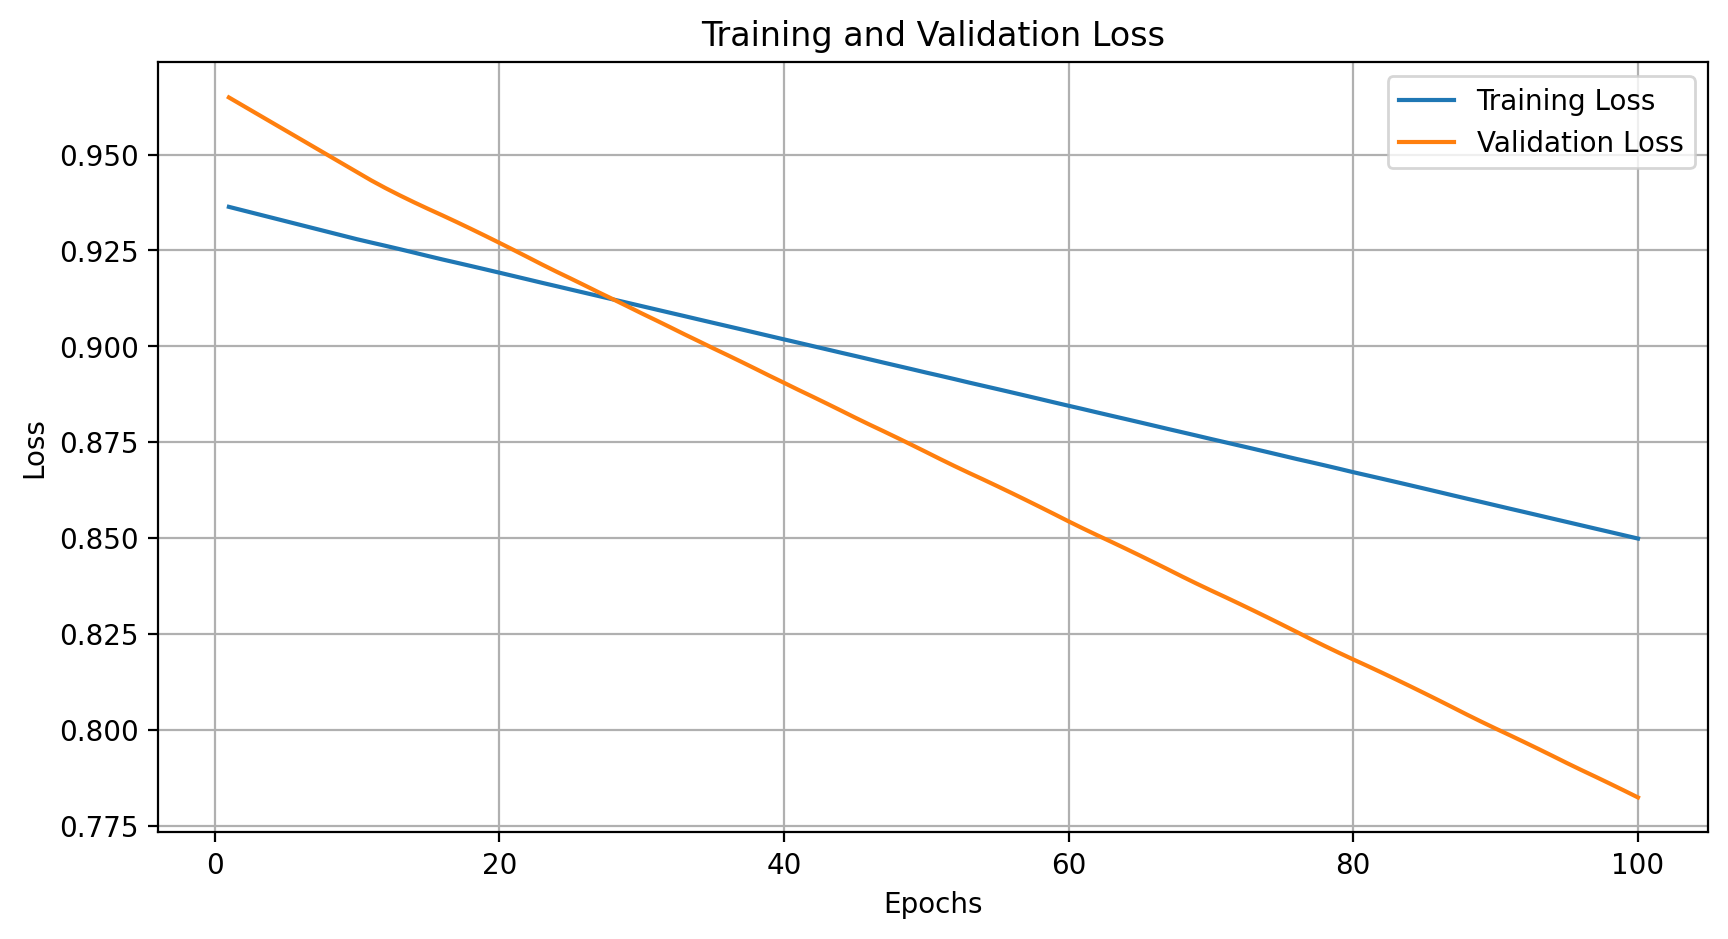

Restoring states from the checkpoint path at D:\Pycharm\chuan\re\emissions\emissions-epoch=99-val_loss=0.78-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\Pycharm\chuan\re\emissions\emissions-epoch=99-val_loss=0.78-v1.ckpt
D:\Anaconda3\envs\beichen\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        FC test_mae        │        175021136.0        │
│        FC test_r2         │    0.6919320225715637     │
└───────────────────────────┴───────────────────────────┘

[{'FC test_mae': 175021136.0, 'FC test_r2': 0.6919320225715637}]

In [51]:
seed_everything(hparams.init_seed) # 固定随机种子

# df:经yeo-johnson变换、排序后的数据 
# pt：变换方法（yeo-johnson）
# df, pt = preprocess_data(hparams.data_path) # 预处理数据并保存变换器
# x, y, pt =create_sequences(hparams.window)
x, y, pt =create_sequencesCO2(hparams.window)

# 创建模型实例
model = EmissionsPredictor(hparams=hparams, pt=pt)

# Trainer
earlystopping = EarlyStopping('val_loss', patience=hparams.patience, verbose=True, min_delta=0.00, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                        mode='min',
                                        dirpath='emissions',
                                        filename='emissions-{epoch:02d}-{val_loss:.2f}',
                                        save_top_k=1)

progress_bar = TQDMProgressBar()

# 训练过程中的损失值会记录在这个列表中
loss_logger = LossLogger()

callback = [earlystopping, checkpoint_callback, loss_logger, progress_bar]

# 记录和超参数记录
trainer = pl.Trainer(max_epochs=hparams.max_epochs, callbacks=callback, accelerator='auto', logger=True)

# DataModule
dm = EmissionsDataModule(hparams=hparams, features=x, targets=y, pt=pt)

trainer.fit(model, datamodule=dm)

best_model_path = trainer.checkpoint_callback.best_model_path

# 测试
trainer.test(
    model=model,
    datamodule=dm,
    ckpt_path=best_model_path
)